In [1]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

In [43]:
def triplet_frequencies(matrix, num_symbols=2, pseudocount=0):
    """
    Calculate triplet frequencies of symbols.

    Parameters
    ----------
    matrix : np.array
        N x L matrix containing N sequences of length L.
        Matrix must be mapped to range(0, num_symbols) using
        map_matrix function
    num_symbols : int
        Number of different symbols contained in alignment
    fi : np.array
        Matrix of size L x num_symbols containing relative
        column frequencies of all characters.

    Returns
    -------
    np.array
        Matrix of size L x L x L x num_symbols x num_symbols x num_symbols containing
        relative triplet frequencies of all character combinations
    """
    N, L = matrix.shape
    fijk = pseudocount*np.ones((L, L, L, num_symbols, num_symbols, num_symbols))
    for s in range(N):
        for i in range(L):
            for j in range(L):
                for k in range(L):
                    fijk[i, j, k, matrix[s, i], matrix[s, j], matrix[s, k]] += 1

    # normalize frequencies by the number
    # of sequences
    fijk /= (N+pseudocount)

    return fijk


In [45]:
@jit(nopython=True)
def triplet_frequencies_fast(matrix, fij, fi, num_symbols=2, pseudocount=0):
    """
    Calculate triplet frequencies of symbols.

    Parameters
    ----------
    matrix : np.array
        N x L matrix containing N sequences of length L.
        Matrix must be mapped to range(0, num_symbols) using
        map_matrix function
    num_symbols : int
        Number of different symbols contained in alignment
    fi : np.array
        Matrix of size L x num_symbols containing relative
        column frequencies of all characters.

    Returns
    -------
    np.array
        Matrix of size L x L x L x num_symbols x num_symbols x num_symbols containing
        relative triplet frequencies of all character combinations
    """
    N, L = matrix.shape
    fijk = pseudocount*np.ones((L, L, L, num_symbols, num_symbols, num_symbols))
    for s in range(N):
        for i in range(L):
            for j in range(i+1, L):
                for k in range(j+1, L):
                    fijk[i, j, k, matrix[s, i], matrix[s, j], matrix[s, k]] += 1
    # set permuted indices to same value
    for i in range(L):
        for j in range(i+1, L):
            for k in range(j+1, L):
                for alpha in range(num_symbols):
                    for beta in range(num_symbols):
                        for gamma in range(num_symbols):
                            value = fijk[i, j, k, alpha, beta, gamma]
                            fijk[i, k, j, alpha, gamma, beta] = value
                            fijk[j, i, k, beta, alpha, gamma] = value
                            fijk[j, k, i, beta, gamma, alpha] = value
                            fijk[k, j, i, gamma, beta, alpha] = value
                            fijk[k, i, j, gamma, alpha, beta] = value

    # normalize frequencies by the number
    # of sequences
    fijk /= (N+pseudocount)
    
    # set the frequency of a doublet
    # in position i to the respective single-site
    # frequency of alpha in position i
    for i in range(L):
        for j in range(i+1, L):
            for alpha in range(num_symbols):
                for beta in range(num_symbols):
                    fijk[i, j, i, alpha, beta, alpha] = fij[i, j, alpha, beta]
                    fijk[i, i, j, alpha, alpha, beta] = fij[i, j, alpha, beta]
                    fijk[j, i, j, beta, alpha, beta] = fij[i, j, alpha, beta]
                    fijk[j, j, i, beta, beta, alpha] = fij[i, j, alpha, beta]
    
    # set the frequency of a triplet
    # in position i to the respective single-site
    # frequency of alpha in position i
    for i in range(L):
        for alpha in range(num_symbols):
            fijk[i, i, i, alpha, alpha, alpha] = fi[i, alpha]

    return fijk


In [47]:
matrix = np.array([[0, 1, 0],
                   [1, 1, 1]])
fi = frequencies(matrix, num_symbols=2)
fij = pair_frequencies(matrix, num_symbols=2, fi=fi)
fijk = triplet_frequencies_fast(matrix, fij=fij, fi=fi, num_symbols=2)
fijk_ref = triplet_frequencies(matrix, num_symbols=2)

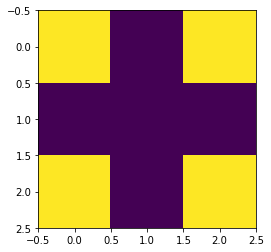

In [48]:
plt.imshow(fijk_ref[0,:,:,0,0,0])

In [49]:
fijk[0,:,:,0,0,0]

array([[0.5, 0. , 0.5],
       [0. , 0. , 0. ],
       [0.5, 0. , 0. ]])

In [50]:
np.testing.assert_array_equal(fijk, fijk_ref)

AssertionError: 
Arrays are not equal

Mismatched elements: 12 / 216 (5.56%)
Max absolute difference: 0.5
Max relative difference: 1.
 x: array([[[[[[0.5, 0. ],
           [0. , 0. ]],
...
 y: array([[[[[[0.5, 0. ],
           [0. , 0. ]],
...